# Classification Lab
### Data Preparation Part 1
<p class="lead">We have been tasked by <em>First Faux Union Bank</em> with developing an algorithm for classifying candidates more likely to sign up for a terms deposit based on historical data.  This <a href="https://jupyter.org/">Jupyter notebook</a>
shows our process for developing the classification model. </p>

<p></p>

<br>
<div class="alert alert-warning">
<b>Assignment:</b> Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.<br><br>
Also, we got marked off last time for not talking about the business side of the mini lab even though the rubric did not mention it at all so we should probably include that in our Markdown as well.
</div>

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use(['seaborn-dark-palette'])

#Import dataset
df = pd.read_csv("bank-additional-full.csv", sep=";")

#View column names
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [2]:
df = df.drop(["duration"], axis=1)

> <p>It doesn't make sense to include the duration of the phone call for prediction purposes.  The call length is not something we will know in advance so we cannot use its value in a classifying model.</p>

In [3]:
df.columns[df.isnull().sum() > 0]

Index([], dtype='object')

> <p>Excellent! it looks like there are no null values to deal with.</p>

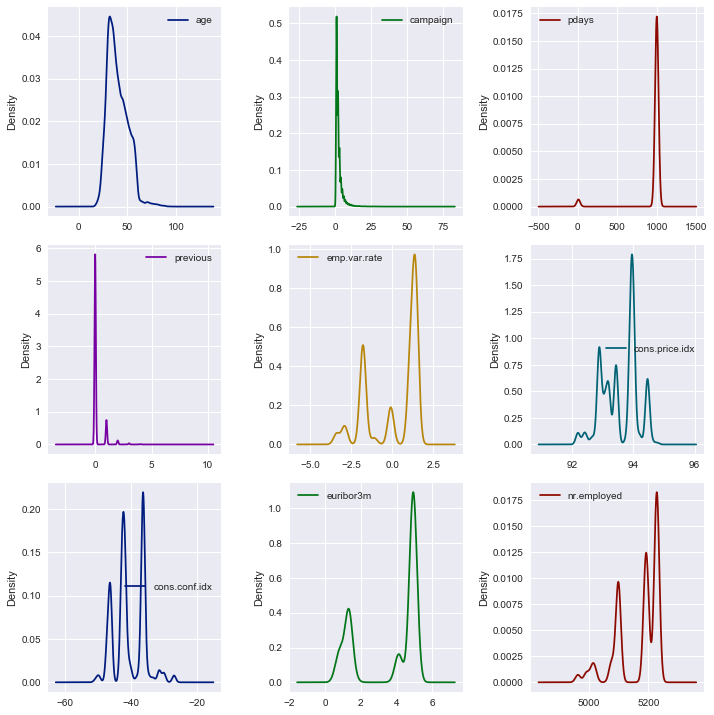

In [4]:
df.plot(kind='density', subplots=True, layout=(3,3), sharex=False, figsize=[10,10])

plt.tight_layout(pad=0.8, w_pad=1.8, h_pad=1.0)

> <p><b>Interpretation:</b> ... </p>

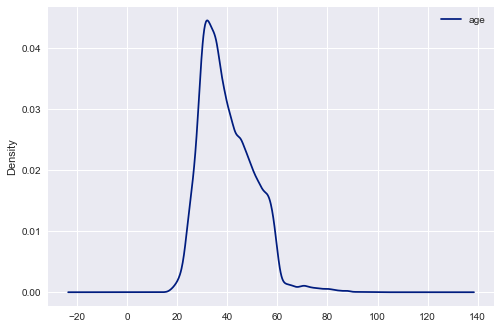

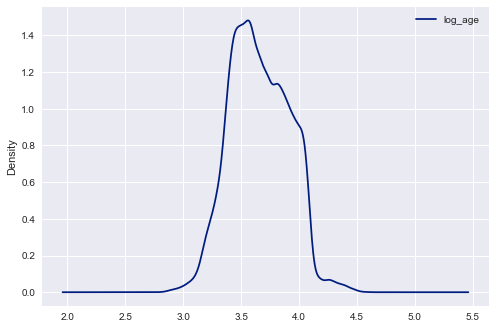

In [5]:
import numpy as np
df.age.plot(kind="density", label="age")
plt.legend(loc='upper right')
plt.show()

log_age = df.age.apply(np.log)
log_age.plot(kind="density", label="log_age")
plt.legend(loc='upper right')
plt.show()

df.age = log_age

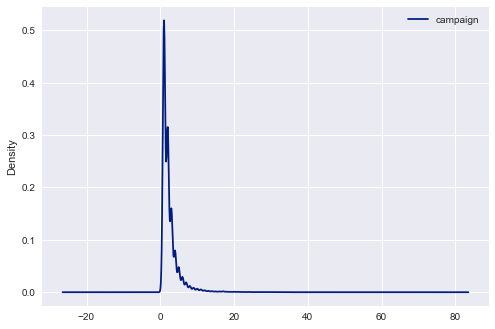

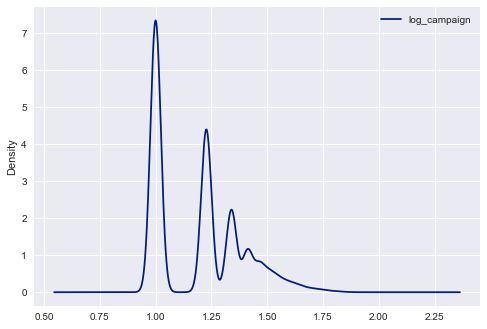

In [6]:
import numpy as np
import math

df.campaign.plot(kind="density", label="campaign")
plt.legend(loc='upper right')
plt.show()

#add epsilon to prevent logs of zero
log_campaign = df.campaign.apply(np.log)
log_campaign.plot(kind="density", label="log_campaign")
plt.legend(loc='upper right')
plt.show()

#df.campaign = log_campaign

> <p><b>Interpretation:</b> After applying log transformations on several different attributes, age seems to fit a more normal distribution. Which is desired. We will keep the transformed attribute and add it into the data frame. Based on other exploratory transformations (not include in this notebook for conciseness) there are not many other variables that gained more optimal distributions from transformations. Therefore, we will exclude any other transformation besides age. A transformation for campaign is also included above to illustrate how transformation are not always valuable, but still an important step in data cleansing. </p> </p>

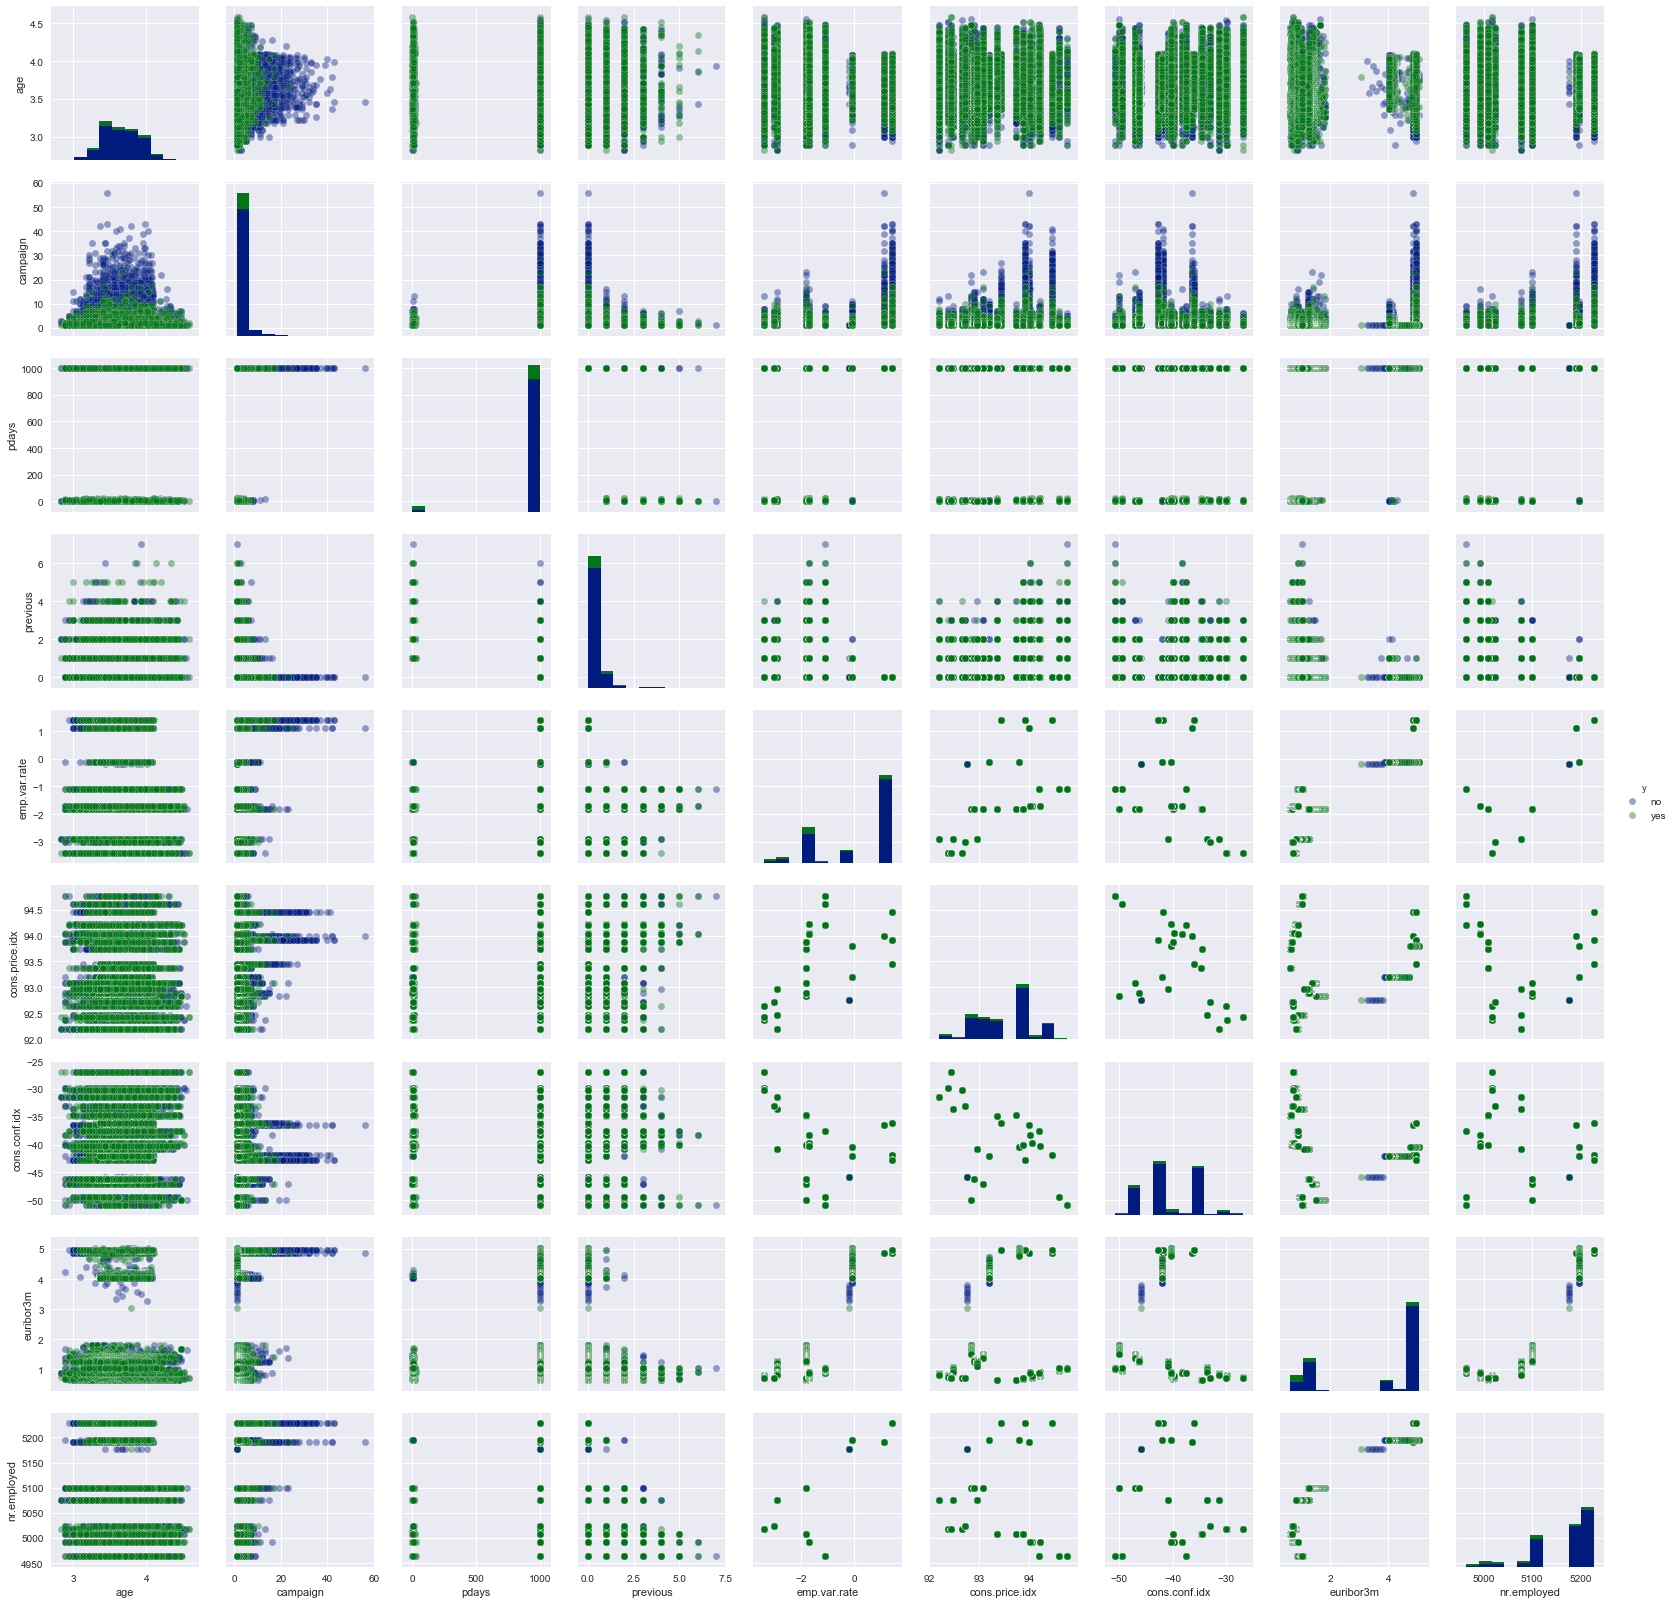

In [7]:
# plt.style.use(['bmh'])
sns.pairplot(df, hue="y", diag_kind="hist", plot_kws={"alpha":.4})

> <p><b>Interpretation:</b> With term deposits (<font color='green'>yes</font>) being green and the lack of the term deposit (<font color='blue'>no</font>) being blue, the pairplot above indicates that strong linear separation is most supported by age, campaign, whether or not the customer had previously signed up for the term deposit, and the current consumer confidence interval (CCI).</p>

><p>Notice the distributions running along the diagonal are not great either, even after our modifications to them. Looking at the distributions of the variables, it is evident that they all have varying skewness. It will be helpful to look at whether transformations fit more normal distributions so that we are meeting more assumptions of the models. The first type of transformation that we will explore is log10 transformation. Given that the age and campaign variables follow the closest normal spread we will apply the log transformation to them first.</p>

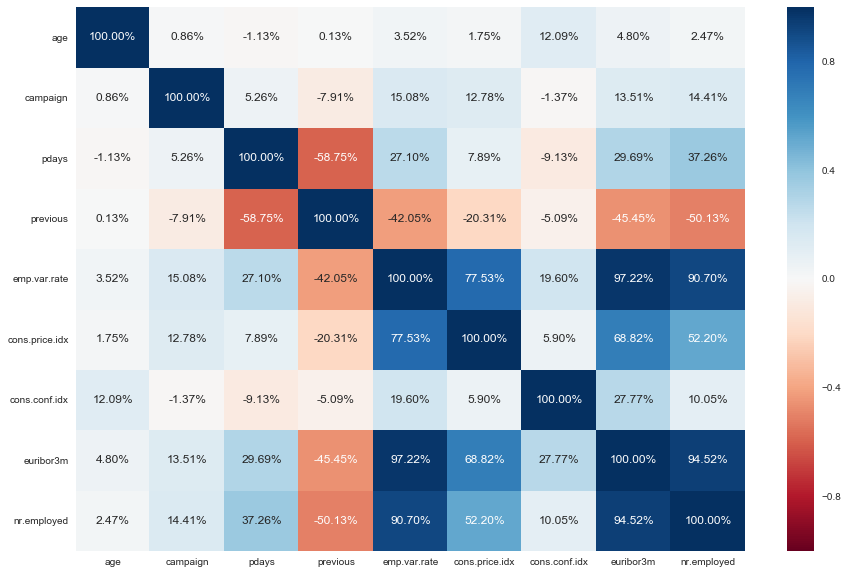

In [8]:
corr = df.corr()
plt.figure(figsize=[15,10])
sns.heatmap(corr,annot=True, fmt=".2%", cmap="RdBu")

> <p><b>Interpretation:</b> The heatmap above is a colorized correlation matrix for easily spotting highly dorrelated variables.  A strong negative correlation is depicted with a <b><font color='darkred'>dark red</font></b> square while a strong positive correlation is depicted with a <b><font color='darkblue'>strong blue</font></b>.  The absolute value or magnitude of the approximate percentage (it is actually the $R^{2}$ value) is the indicator of how strong the correlation is quantitatively.</p>

> <p>From this correlation matrix we can see that `emp.var.rate` is...</p>

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

#get y
y = df.y

#get all but y, also drop duration as it is not suitable for prediction
X = df.drop(["y"], axis=1)

#split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cats = X_train.select_dtypes(include=[np.object])
cats_cols = cats.columns

for i in enumerate(cats_cols):
    i = i[1]
    one_h = pd.get_dummies(X_train[i])
    X_train = X_train.drop(i,axis=1)
    X_train[one_h.columns] = one_h

X_train

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,admin.,...,oct,sep,fri,mon,thu,tue,wed,failure,nonexistent,success
12556,3.688879,2,999,0,1.4,93.918,-42.7,4.960,5228.1,0,...,0,0,0,1,0,0,0,0,1,0
35451,3.433987,4,999,0,-1.8,92.893,-46.2,1.244,5099.1,1,...,0,0,0,1,0,0,0,0,1,0
30592,4.077537,6,999,1,-1.8,92.893,-46.2,1.354,5099.1,0,...,0,0,0,1,0,0,0,1,0,0
17914,3.761200,5,999,0,1.4,93.918,-42.7,4.961,5228.1,0,...,0,0,0,0,0,1,0,0,1,0
3315,3.663562,2,999,0,1.1,93.994,-36.4,4.860,5191.0,1,...,0,0,0,0,1,0,0,0,1,0
29191,3.496508,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,0,...,0,0,1,0,0,0,0,0,1,0
30549,3.555348,3,999,0,-1.8,92.893,-46.2,1.354,5099.1,1,...,0,0,0,1,0,0,0,0,1,0
6098,3.583519,2,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,0,0,1,0,0,1,0
6252,3.583519,2,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,0,0,1,0,0,1,0
13373,3.332205,7,999,0,1.4,93.918,-42.7,4.962,5228.1,0,...,0,0,0,0,0,0,1,0,1,0


In [10]:
from sklearn.preprocessing import StandardScaler

slr = StandardScaler()

X_train = slr.fit_transform(X_train)

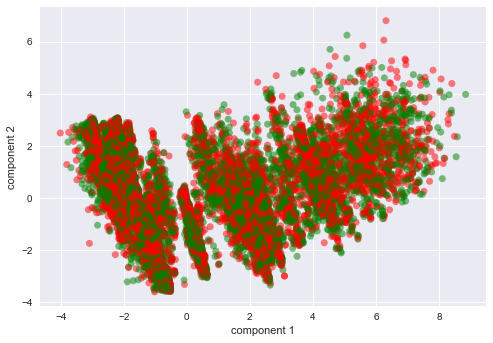

In [11]:
from sklearn.decomposition import PCA

pca_attribs = PCA(n_components=2).fit_transform(X_train)

X_train_pca = pca_attribs

X_train_pca = pd.DataFrame(X_train_pca, columns = ["PCA_1", "PCA_2"])

plt.scatter(X_train_pca["PCA_1"], X_train_pca["PCA_2"],
            c=['r', 'g'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')

> <p><b>Interpretation:</b> PCA....</p>

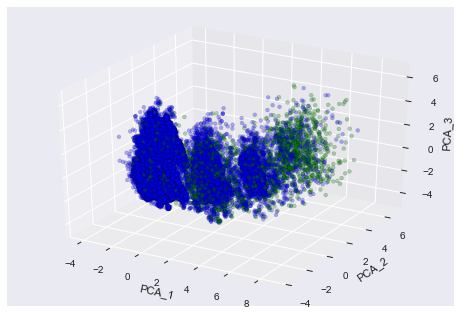

In [12]:
from mpl_toolkits.mplot3d import Axes3D

pca_attribs = PCA(n_components=3).fit_transform(X_train)

X_train_pca = pca_attribs

X_train_pca = pd.DataFrame(X_train_pca, columns = ["PCA_1", "PCA_2", "PCA_3"])

colors = ["green"  if (x == "yes") else "blue" for x in y_train]

threedee = plt.figure().gca(projection='3d')

fig = threedee.scatter(X_train_pca["PCA_1"], X_train_pca["PCA_2"], X_train_pca["PCA_3"], c=colors,s=15,
                           edgecolor='none', alpha=.3,cmap=plt.cm.get_cmap('seismic', 10))

fig = plt.figure(figsize=(20,20))

threedee.set_xlabel('PCA_1')
threedee.set_ylabel('PCA_2')
threedee.set_zlabel('PCA_3')
plt.show()

> <p><b>Interpretation:</b> PCA....</p>

### Data Preparation Part 2
<p></p>

<p></p>

<br>
<div class="alert alert-warning">
<b>Assignment:</b>Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). </div>

> <p>There are three main modifications made to the base data set. The first was explorating different transformations of the continuous variables. Log transformations proved to only help one of the attributes, age. We replaced the <b>`age`</b> attribute with the transformed <b>`log_age`</b> attribute. When evaluating the relevance of the variables we looked at a correlation heatmap of the attributes, relative to the response, as well as used our business domain knowledge to determine which attribute to drop. Campaign was the only one that was removed from the dataset. This attribute measures the duration of the phone call, which is data we will not have for a campaign with news customers.</p> 

> <p>Lastly, we used one hot encoding for categorical variables. It’s important to note that when making dummy variables there needs to be consistency across the train test splits, as to how these variables are transformed. Now that we have explored our data, processed and cleansed it, we can begin our modeling efforts. </p>

### Modeling and Evaluation 1

<div class="alert alert-warning">
<b>Assignment:</b> Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
</div>

> <p> <b>Precision</b>: This is computed based on the ratio of <b>True Positives</b> (<b>TP</b>) relative to the total number of positive predictions, including <b>False Positives</b> (<b>FP</b>). The formula is:</p><br>

> <center><font size=162>$ \frac{TP}{TP + FP}$</font></center>

> <p><b>Precision</b>: is very insightful metrics as it indicates how precise the model is at successfully predicting positive outcomes. We are leveraging this metric to determine the precision of our ability to predict customers who will convert in our marketing campaign. This is highly useful information. Imagine that we run the model before running the marketing campaign, we would be able to isolate the customers who we predict will enroll into the campaign. As a business we can narrow our focus to these customers to make marketing more personal, have outbound calls to these customer, and other approaches that would help solidify their conversion. For the aforementioned reasons, we will include precision in our model evaluation strategy.   </p>

> <p><b>Recall</b>: This is also known as sensitivity. It indicates how the model retrieved instances of the predicted class to relative to the actual number of instances of that particular class. The formula for recall is: (TP / TP + FN). This is a useful metric to balance the insights gained from precision. Precision is great for relevancy but recall is useful for robustness and evaluating how complete the predictions are. As a business, we would leverage recall to continue tuning our model. A lor recall score indicates that we are leaving customers behind from the personalization efforts (mentioned above) that could further supplement our marketing efforts. </p>

### Modeling and Evaluation 2

<div class="alert alert-warning">
<b>Assignment:</b>Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.
</div>	

### Modeling and Evaluation 2

<div class="alert alert-warning">
<b>Assignment:</b>Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.
</div>	

> Stratified 10-fold cross validation... <br><br>
> ...is appropriate because of heavily one-sided data

### Modeling and Evaluation 3

<div class="alert alert-warning">
<b>Assignment:</b>Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!
</div>




> ### Tasks

> <b>1.</b><p>The first classification task will be concerned with determining if the client is likely to sign up for the term deposit based on previous consumer data.</p>

> <b>2.</b><p>The second classification task will take the campaign column, which is a count of the number of previous capmpaigns for the term deposit that have been made, and bin them into <b>3 difficulty categories</b>.  These categories will be able to be interpretted as a blend of the difficulty in obtaining the customer agreement for the term loan and a rough estimate of the amount of corporate time spent advertising to those consumers.  Classification of this column is useful for predicting how much time a salesperson is liable to spend trying to persuade the patron to agree to the term deposit.</p>

<hr>
#### KNN

###### Term Deposit Classification Task


###### Campaign Difficulty Classifier

<hr>
#### SVM

<hr>
#### Random Forest

#### Conclusion
which model for which task and why...

### Modeling and Evaluation 4

<div class="alert alert-warning">
<b>Assignment:</b>Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.
</div>	


### Modeling and Evaluation 5

<div class="alert alert-warning">
<b>Assignment:</b>Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.
</div>	

### Modeling and Evaluation 6

<div class="alert alert-warning">
<b>Assignment:</b>Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.
</div>	

### Deployment

<div class="alert alert-warning">
<b>Assignment:</b>How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?
</div>	

### Exceptional Work

<div class="alert alert-warning">
<b>Assignment:</b>You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?
</div>	